In [ ]:
#Core EDA plots for Housing Adequacy (Canada, 1990–2025)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.dates as mdates

from pathlib import Path

# --------------------------
# Config
# --------------------------
DATA_PATH = "data/housing_adequacy_dataset.csv"
OUTDIR = Path("figs_adequacy_core")
OUTDIR.mkdir(parents=True, exist_ok=True)

plt.rcParams["figure.dpi"] = 140
sns.set_context("notebook")

# --------------------------
# Load + Basic Prep
# --------------------------
df = pd.read_csv(DATA_PATH)

# Parse quarter to Period & timestamp
if "quarter" not in df.columns:
    raise ValueError("Expected a 'quarter' column (e.g., '1990Q1').")
df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q")
df["q_dt"] = df["quarter"].dt.to_timestamp("Q")
df["year"] = df["quarter"].dt.year

# Ensure province exists
if "province" not in df.columns:
    raise ValueError("Expected a 'province' column.")

# Standardize columns used below
# We'll preserve your conventions to match your earlier notebook:
#   - starts_saar_q_dwellings = starts_saar_q * 1000
#   - hai = starts_saar_q_dwellings / needed_units_q
if "starts_saar_q" not in df.columns:
    raise ValueError("Expected 'starts_saar_q' (SAAR, thousands).")
if "needed_units_q" not in df.columns:
    raise ValueError("Expected 'needed_units_q' (quarterly units needed).")

df["starts_saar_q_dwellings"] = df["starts_saar_q"] * 1000.0

# If 'dwelling_starts' column exists, leave it; otherwise create a view alias
if "dwelling_starts" not in df.columns:
    # Keep your SAAR-based dwellings field as the working 'dwelling_starts'
    df["dwelling_starts"] = df["starts_saar_q_dwellings"]

# Provinces order
provinces = sorted(df["province"].unique())


In [ ]:
# %% [ipython] Faceted dual-axis plotting utility (3-per-row grid)

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

def plot_dualaxis_panels(
    df: pd.DataFrame,
    provinces: list,
    left_col: str,
    right_col: str,
    left_label: str | None = None,
    right_label: str | None = None,
    ncols: int = 3,
    outpath: str | None = None,
    left_ls: str = "-",
    right_ls: str = "--",
    left_lw: float = 2.0,
    right_lw: float = 2.0,
    figsize_per_panel=(5.0, 4.0),
    title: str | None = None,
    legend_outside: bool = True,
):
    """
    Plot multiple provinces in a grid (3 per row) with dual y-axes in each panel.
    Left axis plots `left_col`; right axis plots `right_col`.
    - `provinces` length must be a multiple of 3.
    - Distinct colors and line styles per side.
    """
    # ---- Checks ----
    if len(provinces) == 0 or len(provinces) % 3 != 0:
        raise ValueError("`provinces` must be a non-empty list with length as a multiple of 3 (e.g., 3, 6, 9).")

    missing_cols = [c for c in [left_col, right_col, "province"] if c not in df.columns]
    if missing_cols:
        raise ValueError(f"DataFrame missing required columns: {missing_cols}")

    # x-axis time column
    if "q_dt" in df.columns:
        xcol = "q_dt"
    else:
        if "quarter" not in df.columns:
            raise ValueError("DataFrame must have 'q_dt' or 'quarter'.")
        # Create a timestamp for plotting
        tmp = df["quarter"]
        if not isinstance(tmp.dtype, pd.PeriodDtype):
            tmp = pd.PeriodIndex(tmp, freq="Q")
        df = df.copy()
        df["q_dt"] = tmp.to_timestamp("Q")
        xcol = "q_dt"

    # labels
    if left_label is None:
        left_label = LABEL_MAP.get(left_col, left_col.replace("_", " ").title())
    if right_label is None:
        right_label = LABEL_MAP.get(right_col, right_col.replace("_", " ").title())

    # keep only provinces that exist
    provinces = [p for p in provinces if p in df["province"].unique()]
    if len(provinces) == 0:
        raise ValueError("None of the requested provinces are present in the DataFrame.")

    # ---- Layout ----
    n = len(provinces)
    nrows = math.ceil(n / ncols)
    fw, fh = figsize_per_panel
    fig, axes = plt.subplots(nrows, ncols, figsize=(fw * ncols, fh * nrows), sharex=False)
    axes = np.atleast_2d(axes)

    # style
    sns.set_style("whitegrid")
    colors = sns.color_palette("Set2", 2)
    left_color, right_color = colors[0], colors[1]

    # legend handles (one shared)
    leg_handles, leg_labels = [], []

    # ---- Plot each province ----
    for i, p in enumerate(provinces):
        r, c = divmod(i, ncols)
        ax1 = axes[r, c]

        sub = df.loc[df["province"] == p, [xcol, left_col, right_col]].dropna()
        if sub.empty:
            ax1.set_visible(False)
            continue

        # Left axis
        l1, = ax1.plot(
            sub[xcol], sub[left_col],
            color=left_color, ls=left_ls, lw=left_lw, label=left_label
        )
        ax1.set_ylabel(left_label, color=left_color)
        ax1.tick_params(axis="y", colors=left_color)
        ax1.grid(alpha=0.3)

        # Right axis
        ax2 = ax1.twinx()
        l2, = ax2.plot(
            sub[xcol], sub[right_col],
            color=right_color, ls=right_ls, lw=right_lw, label=right_label
        )
        ax2.set_ylabel(right_label, color=right_color)
        ax2.tick_params(axis="y", colors=right_color)

        # X formatting
        ax1.set_xlabel("Quarter")
        ax1.xaxis.set_major_locator(mdates.YearLocator(base=5))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

        # Title
        ax1.set_title(p.upper(), fontsize=12)

        if not leg_handles:
            leg_handles = [l1, l2]
            leg_labels = [h.get_label() for h in leg_handles]

    # Hide unused axes if any
    total_axes = nrows * ncols
    for j in range(n, total_axes):
        r, c = divmod(j, ncols)
        axes[r, c].set_visible(False)

    # Title & legend
    if title is None:
        title = f"{left_label} vs {right_label} — Selected Provinces"
    fig.suptitle(title, y=1.03, fontsize=13)

    if legend_outside:
        #fig.legend(leg_handles, leg_labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.08))
        fig.tight_layout(rect=[0, 0, 1, 0.98])
    else:
        #axes[0, 0].legend(frameon=False, loc="upper left")
        fig.tight_layout(rect=[0, 0, 1, 0.98])

    if outpath:
        fig.savefig(outpath, bbox_inches="tight")
    plt.show()

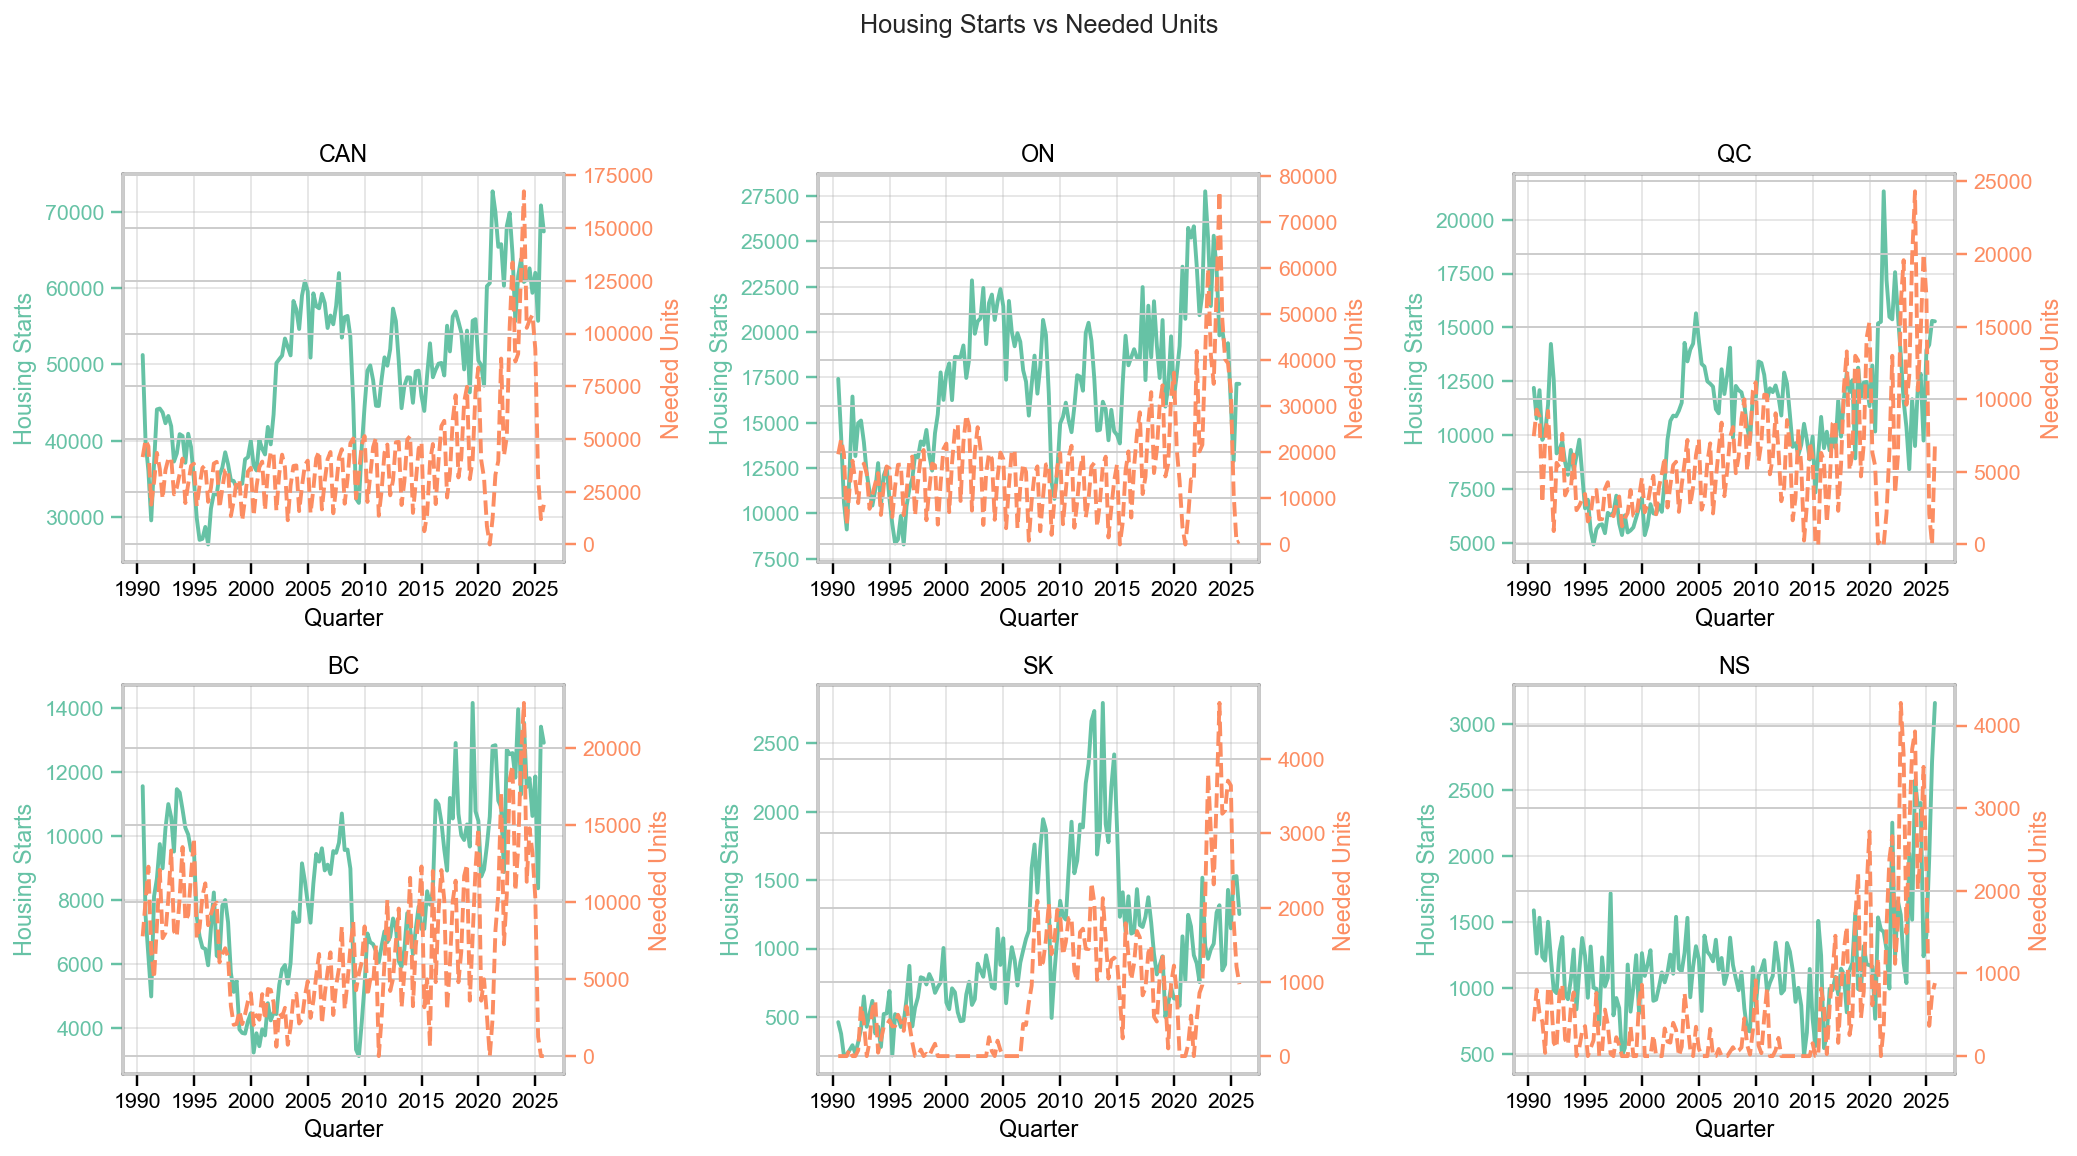

In [ ]:
plot_dualaxis_panels(
    df=df,
    provinces=["can", "on", "qc", "bc", "sk", "ns"],
    left_col="dwelling_starts",
    right_col="needed_units_q",
    left_label="Housing Starts",
    right_label="Needed Units",
    outpath="figs_adequacy_core/panels_starts_vs_needed_3.png",
    title="Housing Starts vs Needed Units"
)

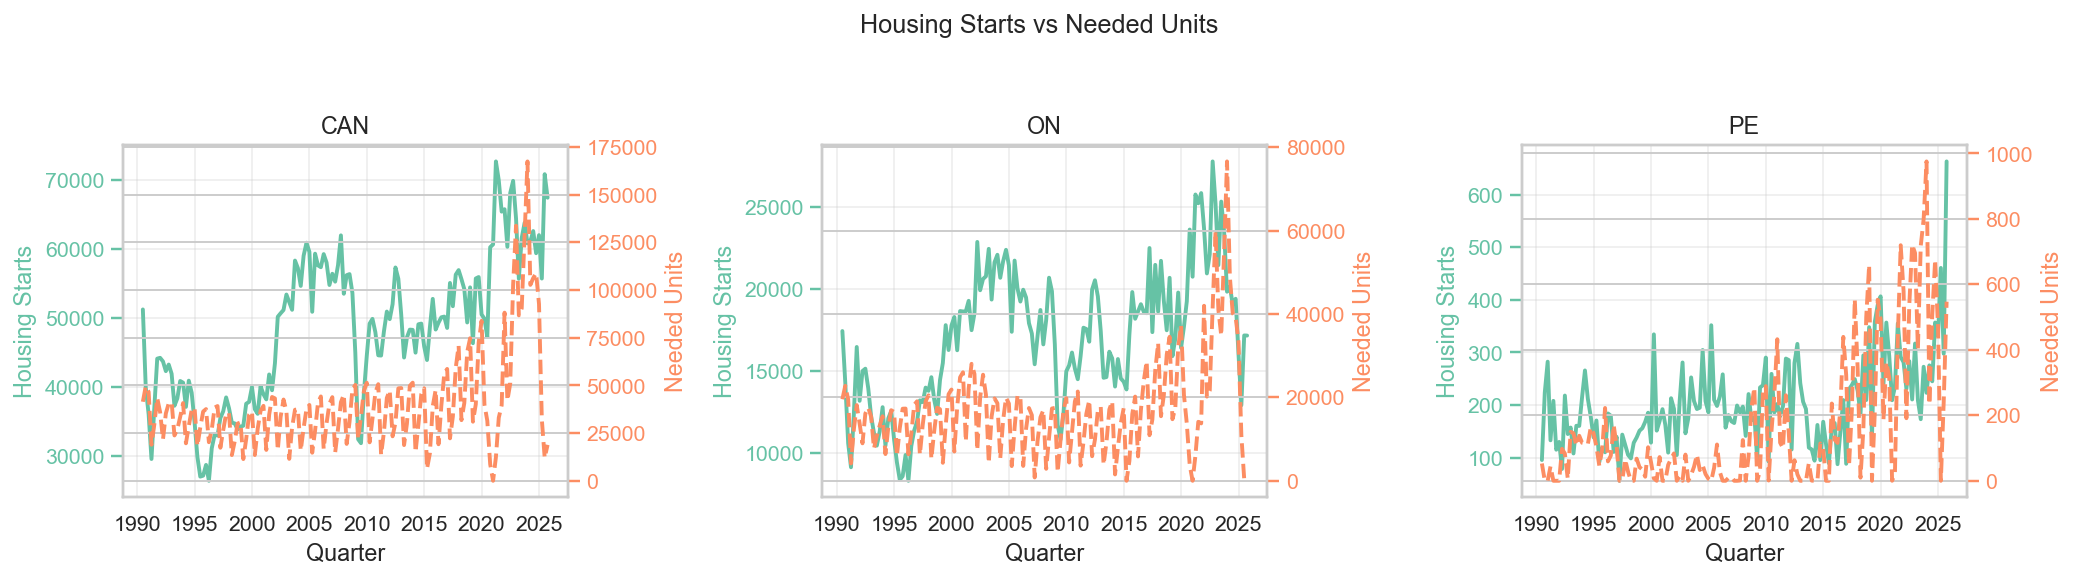

In [ ]:
plot_dualaxis_panels(
    df=df,
    provinces=["can", "on", "pe"],
    left_col="dwelling_starts",
    right_col="needed_units_q",
    left_label="Housing Starts",
    right_label="Needed Units",
    outpath="figs_adequacy_core/panels_starts_vs_needed_3.png",
    title="Housing Starts vs Needed Units"
)

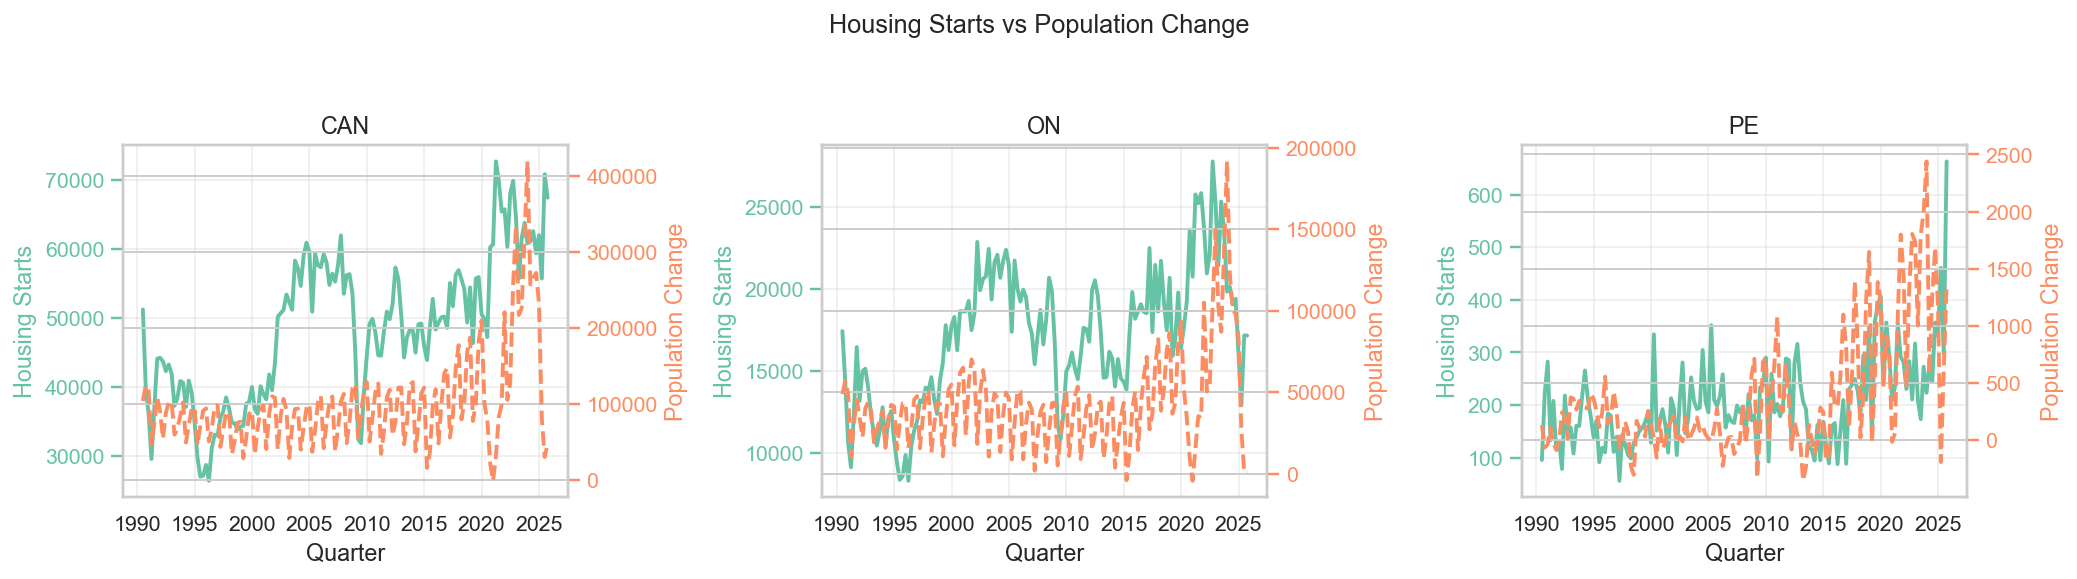

In [ ]:
plot_dualaxis_panels(
    df=df,
    provinces=["can", "on", "pe"],
    left_col="dwelling_starts",
    right_col="pop_change_q",
    left_label="Housing Starts",
    right_label="Population Change",
    outpath="figs_adequacy_core/panels_starts_vs_pop_3.png",
    title="Housing Starts vs Population Change"
)

In [ ]:
LABEL_MAP = {
    "quarter": "Quarter",
    "province": "Province",
    "population": "Population",
    "starts_saar": "Housing Starts (SAAR, 000s)",
    "starts_saar_q": "Housing Starts (Quarterly, 000s)",
    "starts_saar_q_dwellings": "Housing Starts (Dwellings)",
    "dwelling_starts": "Housing Starts (Dwellings)",
    "pop_change_q": "ΔPopulation (Quarterly)",
    "needed_units_q": "Needed Housing Units (Quarterly)",
    "hai": "Housing Adequacy Index (HAI)",
    "q_dt": "Quarter Date",
    "year": "Year"
}

In [ ]:
# %% [ipython] Box plots for outlier checks across provinces & metrics (with linear/log/symlog scales)
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_box_outliers(
    df: pd.DataFrame,
    metrics: list,
    provinces: list | None = None,
    ncols: int = 2,
    show_points: bool = True,
    yscale: str = "linear",             # <--- NEW ("linear", "log", "symlog")
    symlog_thresh: float = 1.0,         # <--- NEW (only used if yscale="symlog")
    whis: float | tuple = 1.5,
    outpath: str | None = None,
    title: str | None = None,
    figsize_per_panel=(5.8, 4.2),
    order_provinces: bool = True,
):
    """
    Box plots to inspect outliers for multiple metrics across provinces.
    Supports 'linear', 'log', and 'symlog' y-axis scaling.

    Parameters
    ----------
    df : DataFrame with columns: 'province' and metrics.
    metrics : list of str
        Numeric columns to plot (one subplot per metric).
    provinces : list[str] | None
        Subset of provinces to include. If None, use all.
    ncols : int
        Number of subplot columns (panels = len(metrics)).
    show_points : bool
        Overlay a stripplot of individual observations.
    yscale : str
        One of {"linear", "log", "symlog"}.
    symlog_thresh : float
        Linear range threshold for symlog scale.
    whis : float | tuple
        Whisker length for boxplot (default 1.5 IQR).
    outpath : str | None
        If provided, save the figure to this path.
    title : str | None
        Figure suptitle.
    figsize_per_panel : (w, h)
        Size per subplot panel.
    order_provinces : bool
        If True, order provinces by median value (per metric) descending.
    """
    if "province" not in df.columns:
        raise ValueError("DataFrame must have a 'province' column.")

    # province filter
    if provinces is not None:
        keep = set(provinces)
        work = df[df["province"].isin(keep)].copy()
    else:
        work = df.copy()

    # long format for seaborn
    long = work.melt(id_vars=["province"], value_vars=metrics, var_name="metric", value_name="value")
    long = long.dropna(subset=["value"])

    # layout
    m = len(metrics)
    ncols = max(1, ncols)
    nrows = math.ceil(m / ncols)
    fw, fh = figsize_per_panel
    fig, axes = plt.subplots(nrows, ncols, figsize=(fw * ncols, fh * nrows), squeeze=False)
    sns.set_style("whitegrid")

    for i, metric in enumerate(metrics):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        data_i = long[long["metric"] == metric].copy()
        if data_i.empty:
            ax.set_visible(False)
            continue

        # province order (by median for this metric)
        if order_provinces:
            med = (data_i.groupby("province")["value"]
                          .median()
                          .sort_values(ascending=False))
            x_order = med.index.tolist()
        else:
            x_order = sorted(data_i["province"].unique().tolist())

        display_map = {p: p.upper() for p in x_order}

        # --- Draw boxplot ---
        sns.boxplot(
            data=data_i,
            x="province", y="value",
            order=x_order,
            whis=whis, showfliers=True,
            color=sns.color_palette("Set2", 1)[0],
            ax=ax
        )

        # --- Overlay points ---
        if show_points:
            sns.stripplot(
                data=data_i,
                x="province", y="value",
                order=x_order,
                dodge=False, jitter=0.15,
                alpha=0.35, size=2.0, color="black",
                ax=ax
            )

        # --- Axis labels & title ---
        ax.set_xticklabels([display_map[p] for p in x_order], rotation=30, ha="right")
        ax.set_xlabel("Province")
        ax.set_ylabel(LABEL_MAP.get(metric, metric.replace("_", " ").title()))
        ax.set_title(f"Outlier Check — {LABEL_MAP.get(metric, metric.replace('_', ' ').title())}", fontsize=11)

        # --- Set y-scale ---
        if yscale == "log":
            if (data_i["value"] > 0).all():
                ax.set_yscale("log")
            else:
                ax.text(0.02, 0.92, "log skipped (≤0 values)",
                        transform=ax.transAxes, fontsize=9, color="crimson")
        elif yscale == "symlog":
            ax.set_yscale("symlog", linthresh=symlog_thresh)
        else:
            ax.set_yscale("linear")

    # hide any unused panels
    total_axes = nrows * ncols
    for j in range(m, total_axes):
        r, c = divmod(j, ncols)
        axes[r, c].set_visible(False)

    if title is None:
        title = f"Box Plots for Outlier Inspection ({yscale} scale)"
    fig.suptitle(title, y=1.02, fontsize=13)
    fig.tight_layout(rect=[0, 0, 1, 0.98])

    if outpath:
        fig.savefig(outpath, bbox_inches="tight")
    plt.show()


### 
['quarter',
 'province',
 'population',
 'starts_saar',
 'starts_saar_q',
 'dwelling_starts',
 'pop_change_q',
 'needed_units_q',
 'hai',
 'q_dt',
 'year',
 'starts_saar_q_dwellings']

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_36018/2675371159.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([display_map[p] for p in x_order], rotation=30, ha="right")


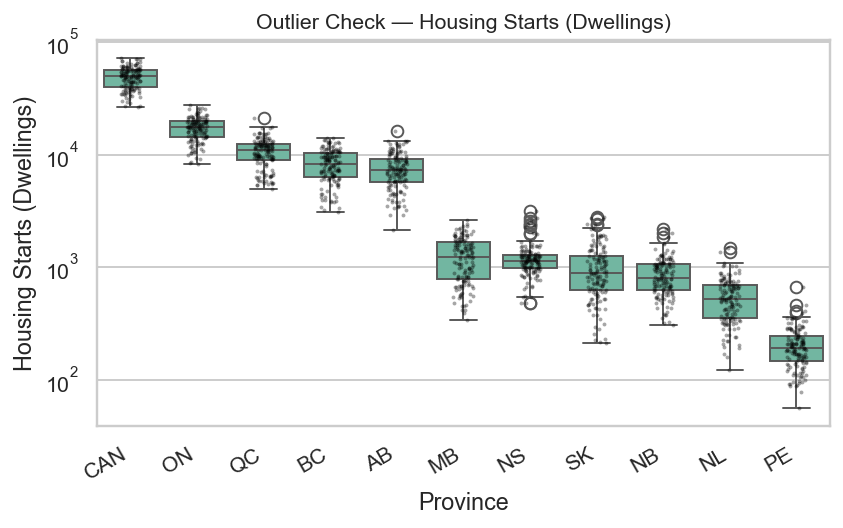

In [ ]:
plot_box_outliers(
    df=df,
    metrics=["dwelling_starts"],
    yscale="log",
    title=""
)


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_36018/2675371159.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([display_map[p] for p in x_order], rotation=30, ha="right")


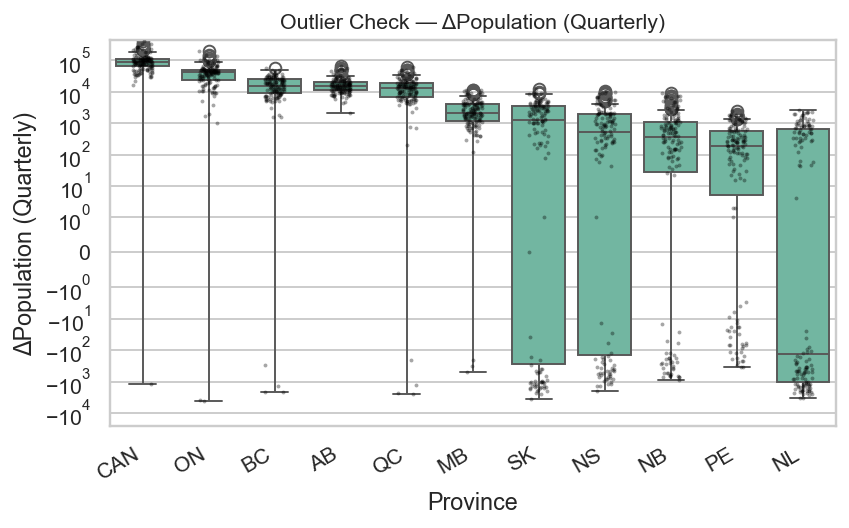

In [ ]:
plot_box_outliers(
    df=df,
    metrics=["pop_change_q"],
    yscale="symlog",
    title=""
)

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_36018/2675371159.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([display_map[p] for p in x_order], rotation=30, ha="right")


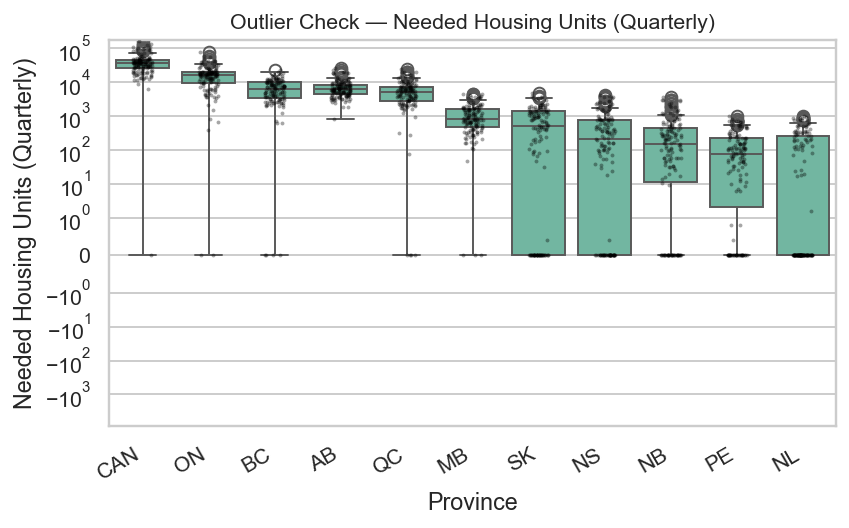

In [ ]:
plot_box_outliers(
    df=df,
    metrics=["needed_units_q"],
    yscale="symlog",
    title=""
)

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_36018/2675371159.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([display_map[p] for p in x_order], rotation=30, ha="right")


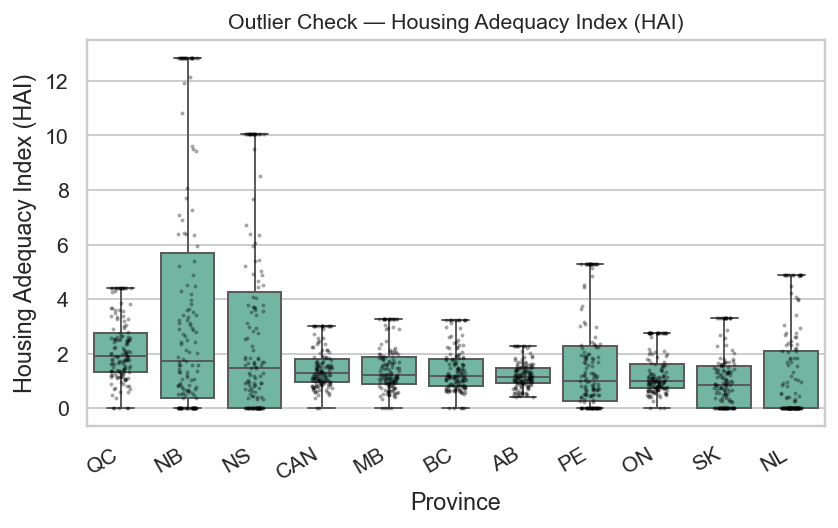

In [ ]:
plot_box_outliers(
    df=df,
    metrics=["hai"],
    yscale="linear",
    title=""
)

In [ ]:
# %% [ipython] Correlation heatmaps averaged over a time period (overall or per-province)
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Optional (else the function will fall back to key -> title-cased)
try:
    LABEL_MAP
except NameError:
    LABEL_MAP = {}

def _ensure_qdt(df: pd.DataFrame) -> pd.DataFrame:
    if "q_dt" in df.columns:
        return df
    if "quarter" not in df.columns:
        raise ValueError("DataFrame must contain 'q_dt' or 'quarter' for time axis.")
    q = df["quarter"]
    if not isinstance(q.dtype, pd.PeriodDtype):
        q = pd.PeriodIndex(q, freq="Q")
    df = df.copy()
    df["q_dt"] = q.to_timestamp("Q")
    return df

def _pretty(name: str) -> str:
    return LABEL_MAP.get(name, name.replace("_", " ").title())

def plot_corr_over_period(
    df: pd.DataFrame,
    cols: list[str],
    *,
    provinces: list[str] | None = None,
    by_province: bool = True,
    start: str | pd.Timestamp | None = None,   # e.g., "2000-01-01" or "2000"
    end: str | pd.Timestamp | None = None,     # e.g., "2025-12-31" or "2025"
    freq: str = "A",                            # 'A' (annual), 'Q' (quarterly), 'M' (monthly), None for raw
    method: str = "pearson",                    # 'pearson' or 'spearman'
    cmap: str = "coolwarm",
    vmin: float = -1.0,
    vmax: float = 1.0,
    annot: bool = True,
    decimals: int = 2,
    figsize_per_panel: tuple[float, float] = (5.6, 5.2),
    ncols: int = 3,
    title: str | None = None,
    outpath: str | None = None,
):
    """
    Plot correlation matrices for selected columns after aggregating to a time frequency.
    - If by_province=False: one heatmap using all rows (optionally filtered/aggregated).
    - If by_province=True: one heatmap per province (3 per row).
    """
    if "province" not in df.columns and by_province:
        raise ValueError("DataFrame must have 'province' when by_province=True.")

    if not cols or len(cols) < 2:
        raise ValueError("Provide at least two columns in `cols` to compute correlations.")

    # Ensure timestamp column
    df = _ensure_qdt(df)

    # Filter date range
    work = df.copy()
    if start is not None:
        work = work[work["q_dt"] >= pd.to_datetime(start)]
    if end is not None:
        work = work[work["q_dt"] <= pd.to_datetime(end)]

    # Keep only necessary columns
    keep_cols = ["q_dt"] + (["province"] if "province" in work.columns else []) + cols
    work = work.loc[:, [c for c in keep_cols if c in work.columns]]

    # Resample/aggregate to freq (mean), per province if present
    if freq is not None:
        if "province" in work.columns:
            work = (work
                    .set_index("q_dt")
                    .groupby("province")
                    .resample(freq)
                    .mean(numeric_only=True)
                    .reset_index())
        else:
            work = (work
                    .set_index("q_dt")
                    .resample(freq)
                    .mean(numeric_only=True)
                    .reset_index())

    # Helper: compute correlation matrix safely
    def _corr(df_sub: pd.DataFrame) -> pd.DataFrame:
        data = df_sub[cols].copy()
        if method == "spearman":
            return data.corr(method="spearman")
        return data.corr(method="pearson")

    # Plotting
    sns.set_style("whitegrid")

    if not by_province or "province" not in work.columns:
        corr = _corr(work.dropna(subset=cols))
        fig, ax = plt.subplots(figsize=figsize_per_panel)
        sns.heatmap(
            corr, annot=annot, fmt=f".{decimals}f",
            cmap=cmap, vmin=vmin, vmax=vmax, square=True, ax=ax,
            cbar_kws={"label": f"{method.title()} r"}
        )
        ax.set_xticklabels([_pretty(c) for c in corr.columns], rotation=30, ha="right")
        ax.set_yticklabels([_pretty(c) for c in corr.index], rotation=30)
        ttl = title or f"Correlation ({method}) over period"
        ax.set_title(ttl)
        fig.tight_layout()
        if outpath:
            fig.savefig(outpath, bbox_inches="tight")
        plt.show()
        return

    # Per-province panels
    if provinces is None:
        provinces = sorted(work["province"].dropna().unique().tolist())
    else:
        provinces = [p for p in provinces if p in work["province"].unique()]

    n = len(provinces)
    if n == 0:
        raise ValueError("No matching provinces found to plot.")

    nrows = math.ceil(n / ncols)
    fw, fh = figsize_per_panel
    fig, axes = plt.subplots(nrows, ncols, figsize=(fw * ncols, fh * nrows), squeeze=False)

    for i, p in enumerate(provinces):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        sub = work[work["province"] == p].dropna(subset=cols)
        if sub.empty:
            ax.set_visible(False)
            continue

        corr = _corr(sub)
        sns.heatmap(
            corr, annot=annot, fmt=f".{decimals}f",
            cmap=cmap, vmin=vmin, vmax=vmax, square=True, ax=ax,
            cbar=False  # cleaner in panels; add shared colorbar if you want
        )
        ax.set_xticklabels([_pretty(c) for c in corr.columns], rotation=30, ha="right")
        ax.set_yticklabels([_pretty(c) for c in corr.index], rotation=30)
        ax.set_title(p.upper(), fontsize=11)

    # Hide unused panels
    total_axes = nrows * ncols
    for j in range(n, total_axes):
        r, c = divmod(j, ncols)
        axes[r, c].set_visible(False)

    suptitle = title or f"Correlation ({method}) — aggregated at {freq}"
    fig.suptitle(suptitle, y=1.02, fontsize=13)
    fig.tight_layout(rect=[0, 0, 1, 0.98])

    if outpath:
        fig.savefig(outpath, bbox_inches="tight")
    plt.show()


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_36018/1643909400.py:81: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(freq)
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_36018/1643909400.py:82: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


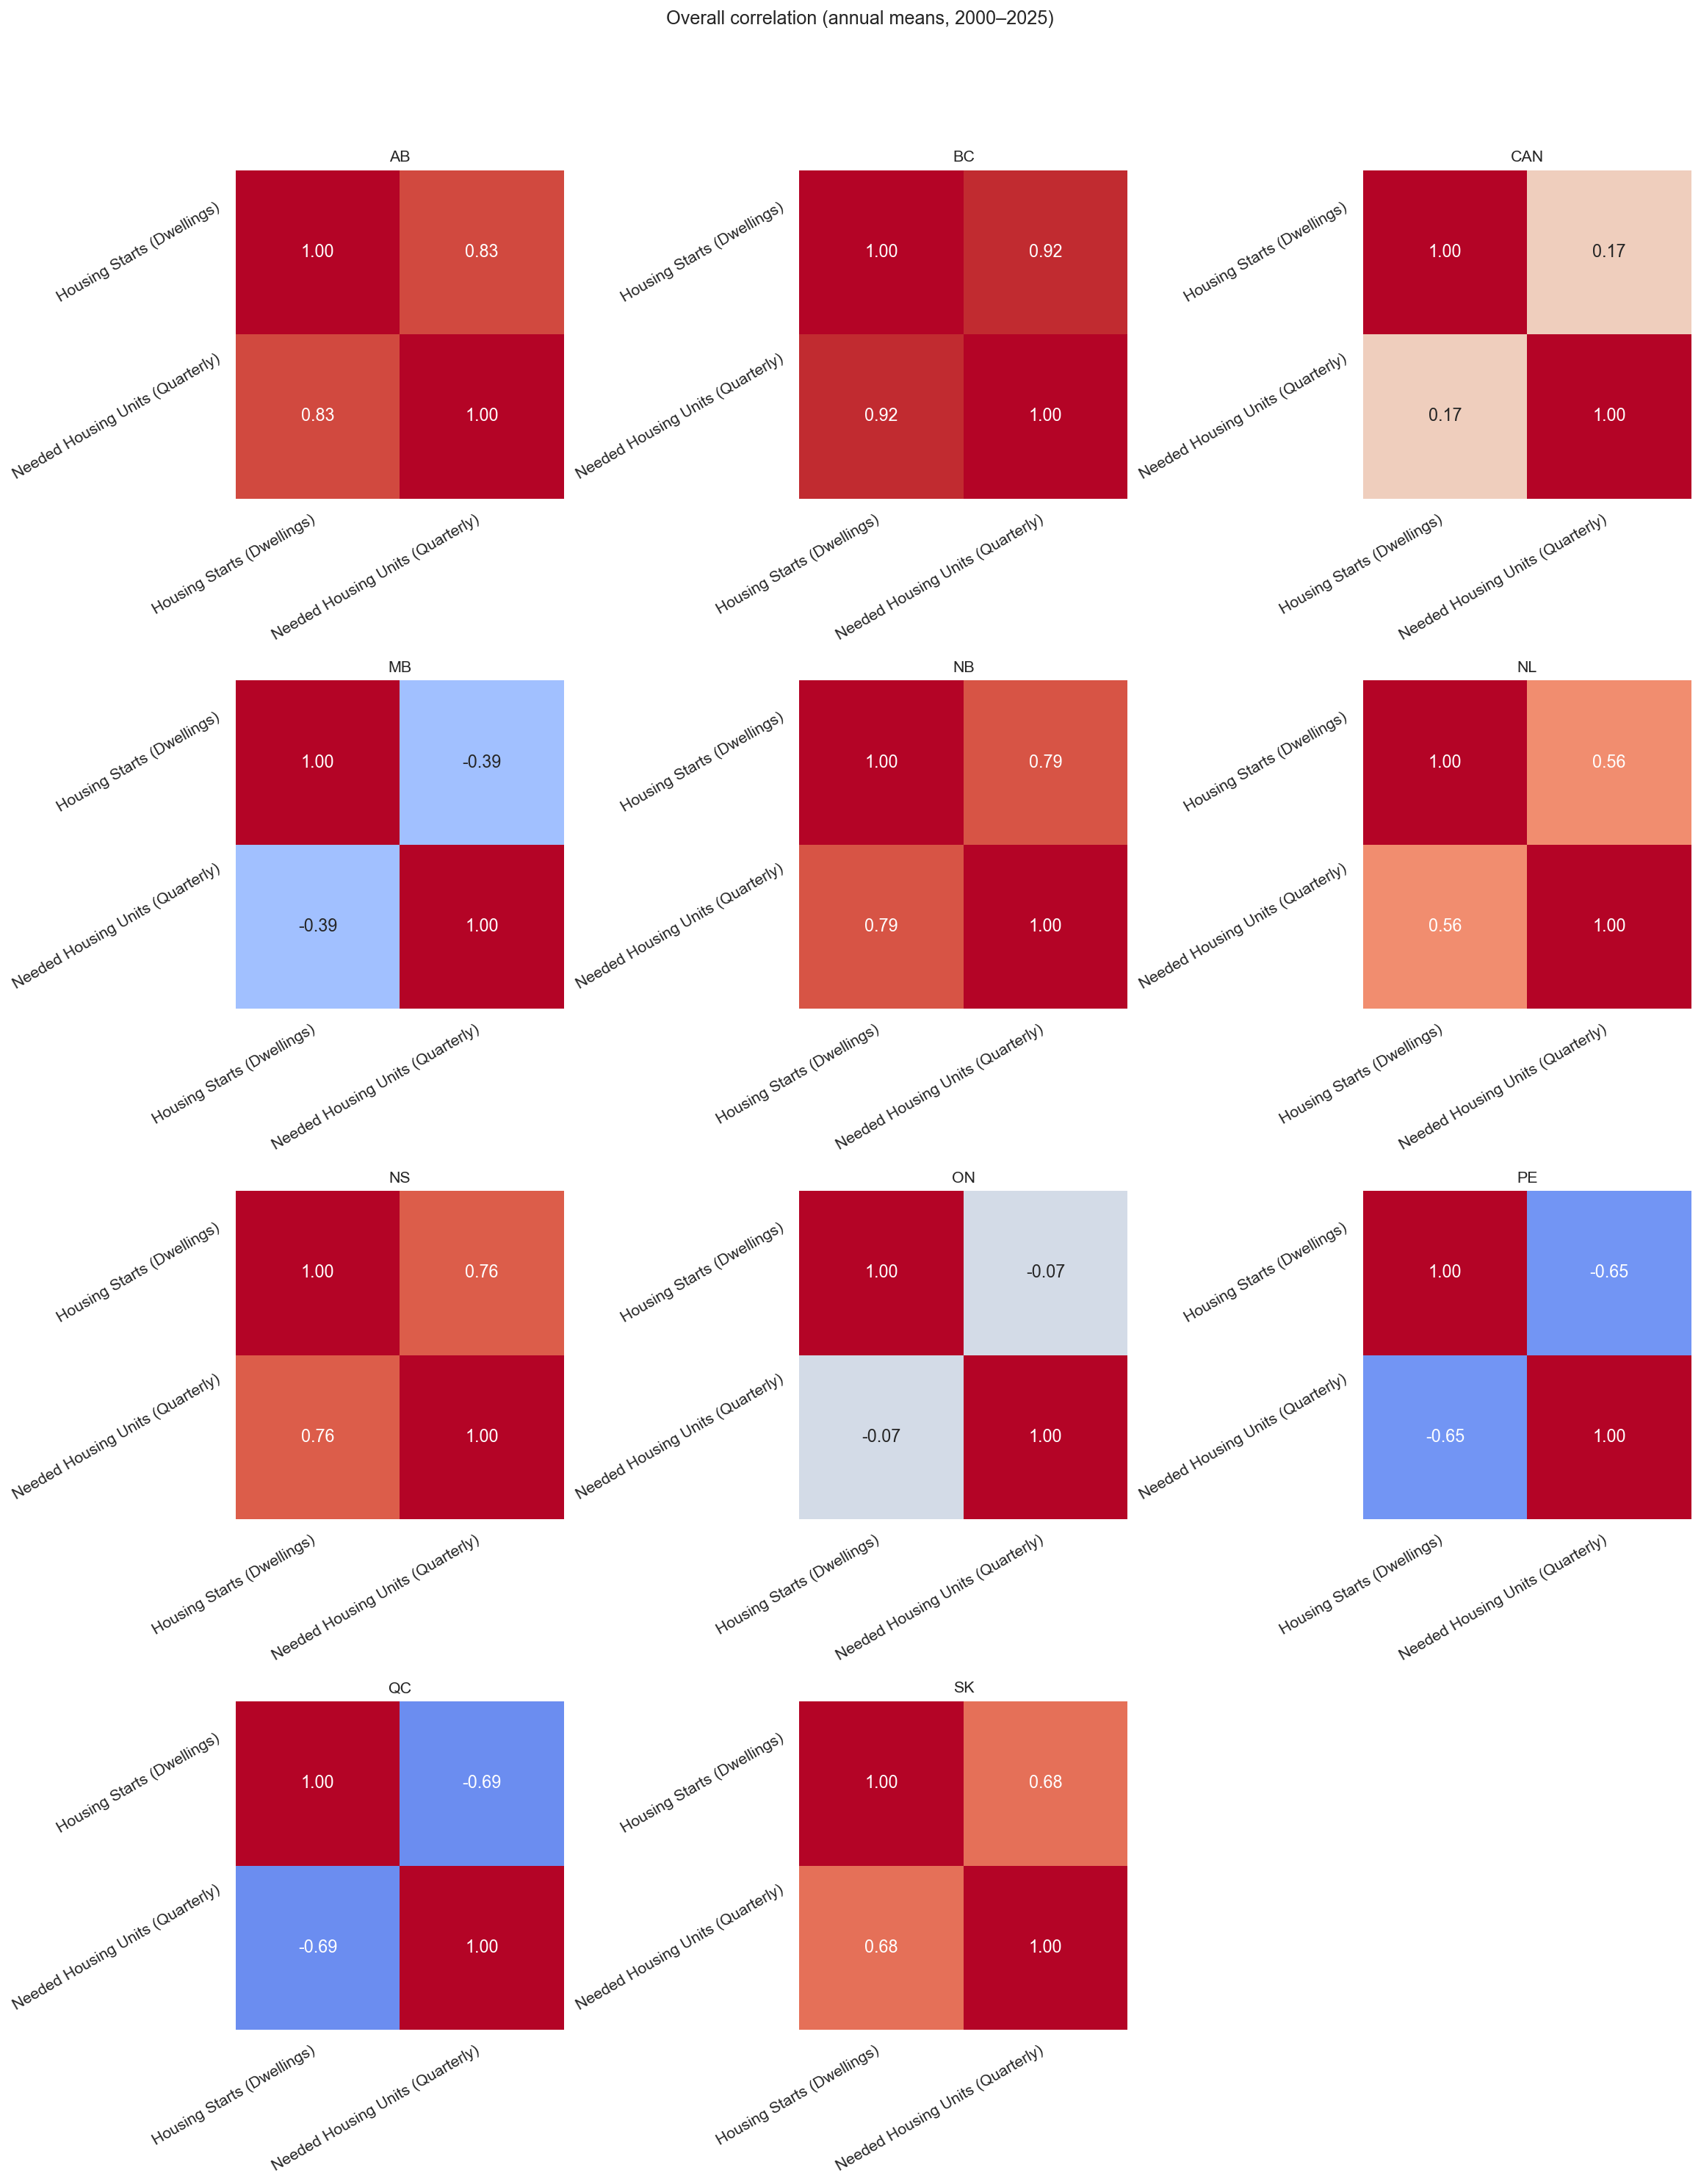

In [ ]:
plot_corr_over_period(
    df=df,
    cols=["dwelling_starts", "needed_units_q"],
    by_province=True,
    start="2020-01-01",
    end="2024-12-31",
    freq="A",
    method="pearson",
    title="Overall correlation (annual means, 2000–2025)"
)


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_36018/1643909400.py:81: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(freq)
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_36018/1643909400.py:82: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


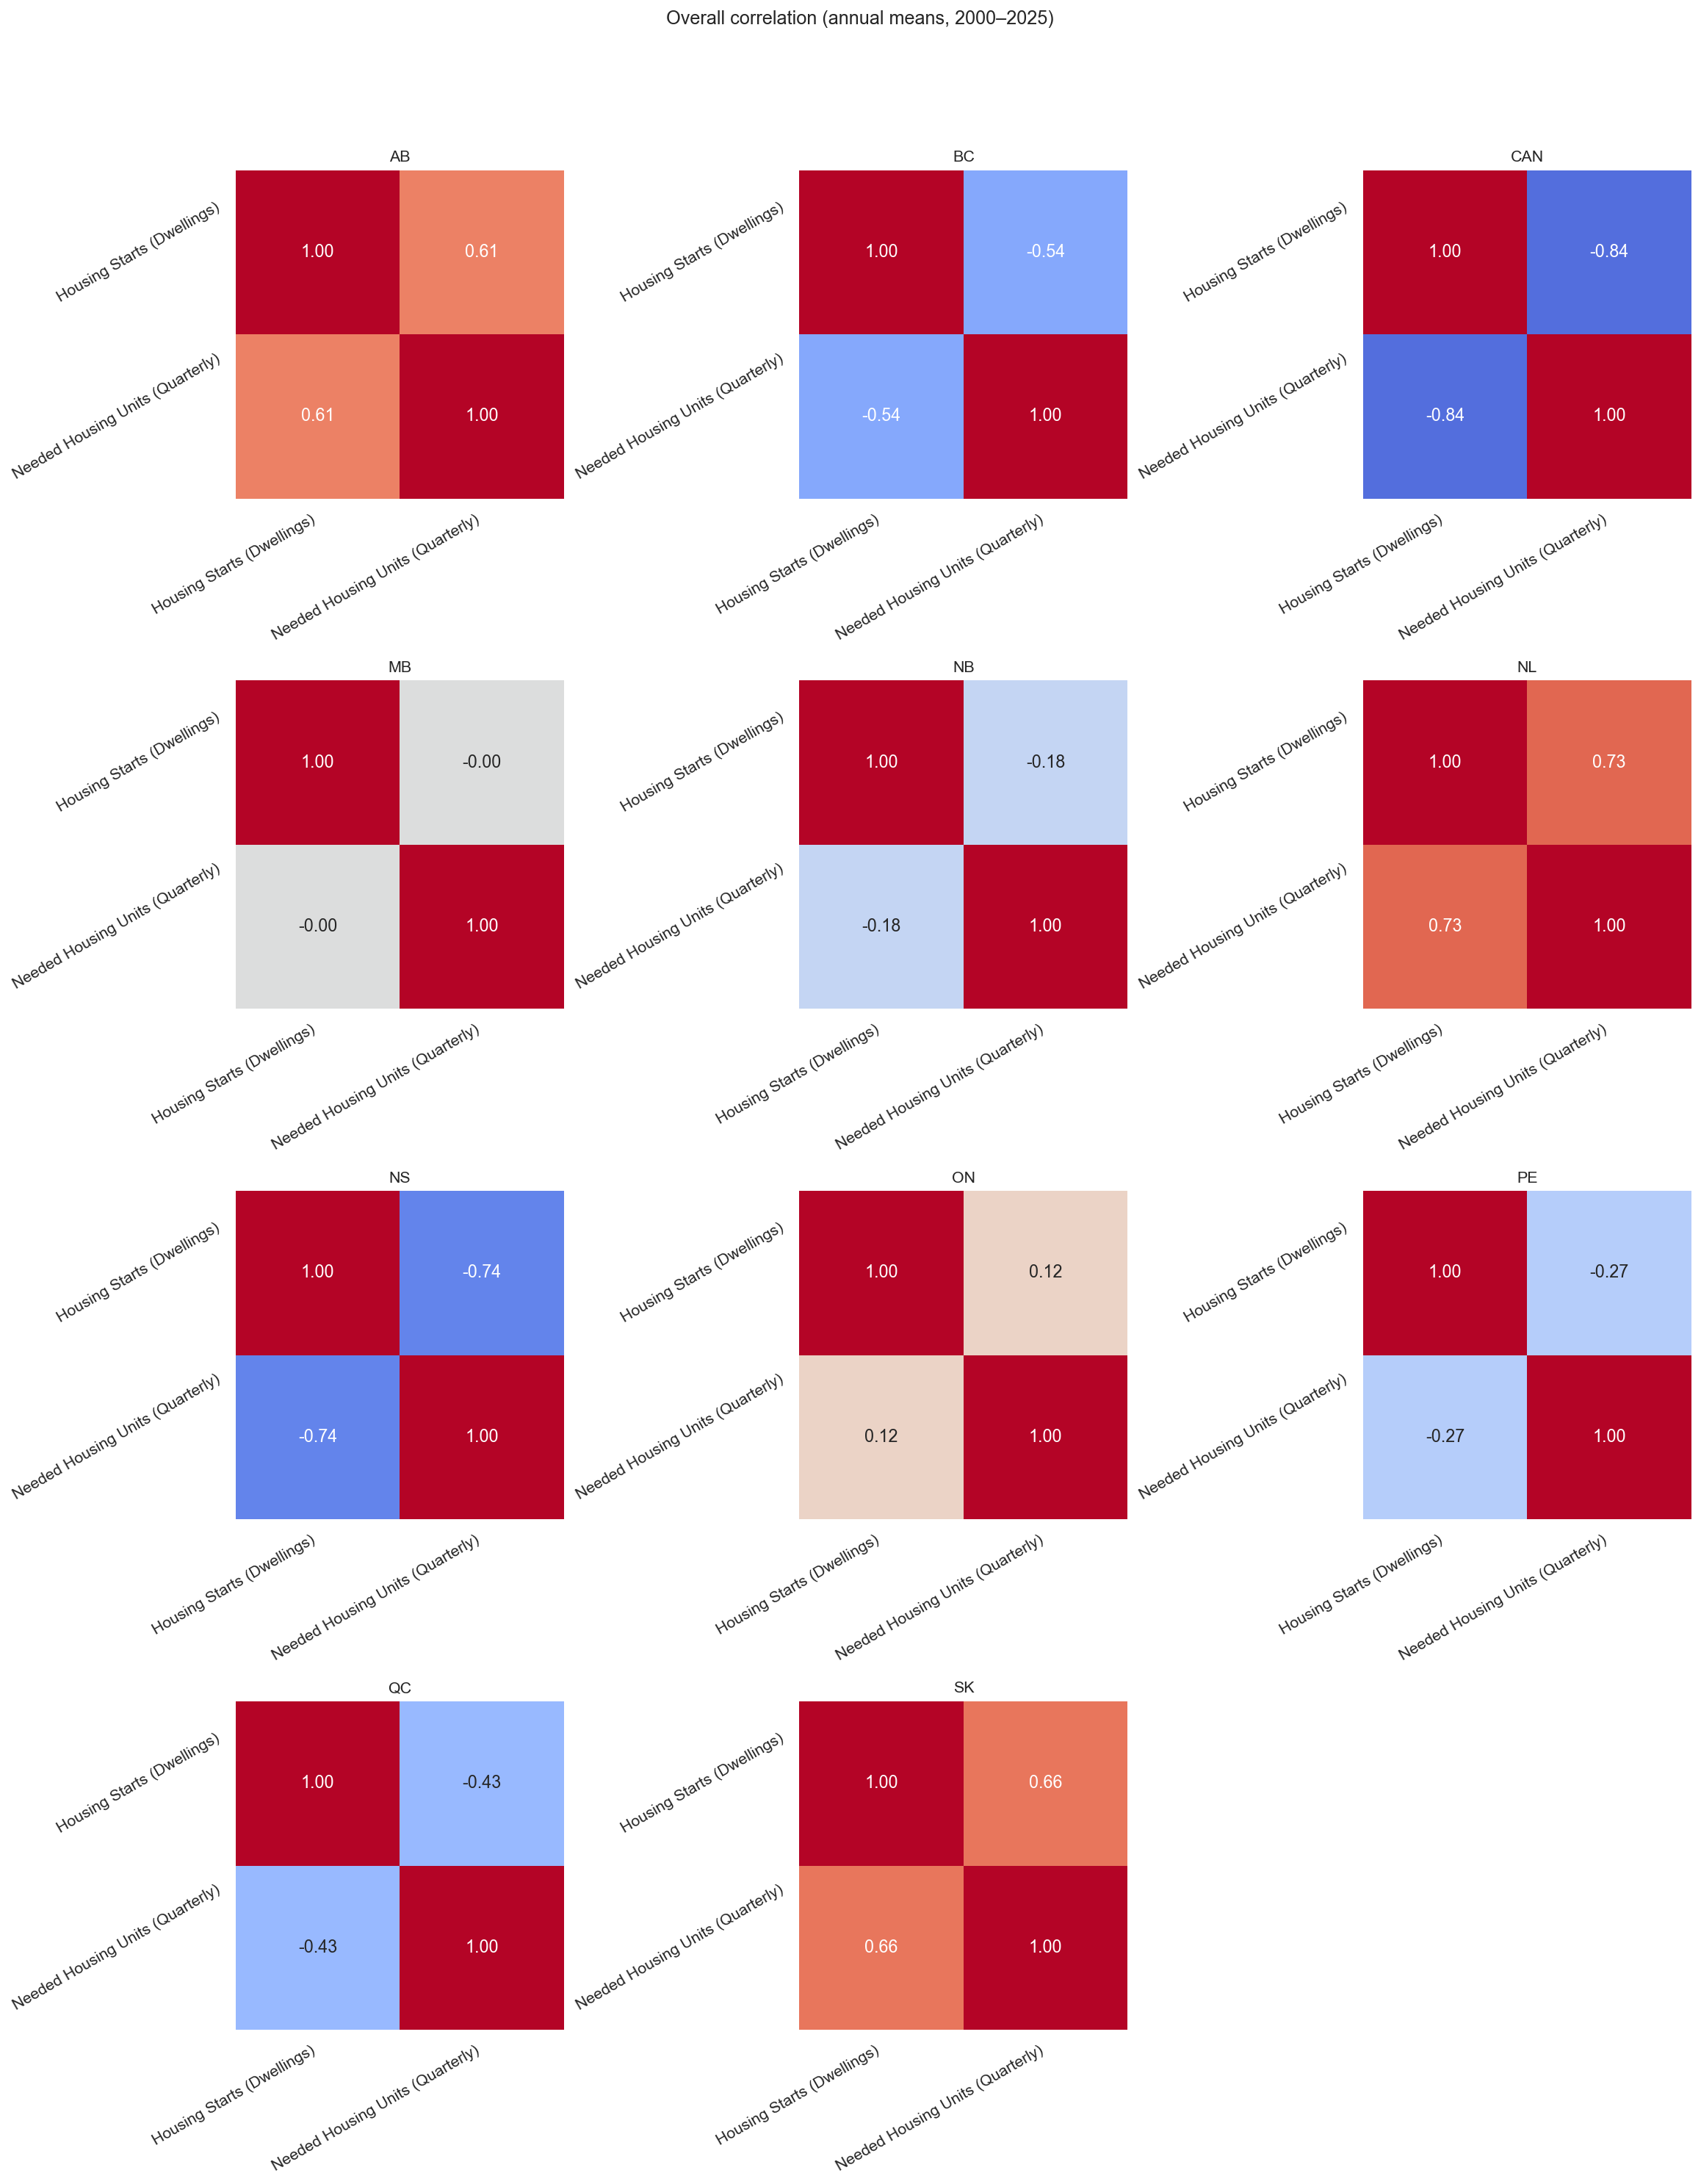

In [ ]:
plot_corr_over_period(
    df=df,
    cols=["dwelling_starts", "needed_units_q"],
    by_province=True,
    start="2005-01-01",
    end="2010-12-31",
    freq="A",
    method="pearson",
    title="Overall correlation (annual means, 2000–2025)"
)

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_36018/1643909400.py:81: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(freq)
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_36018/1643909400.py:82: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


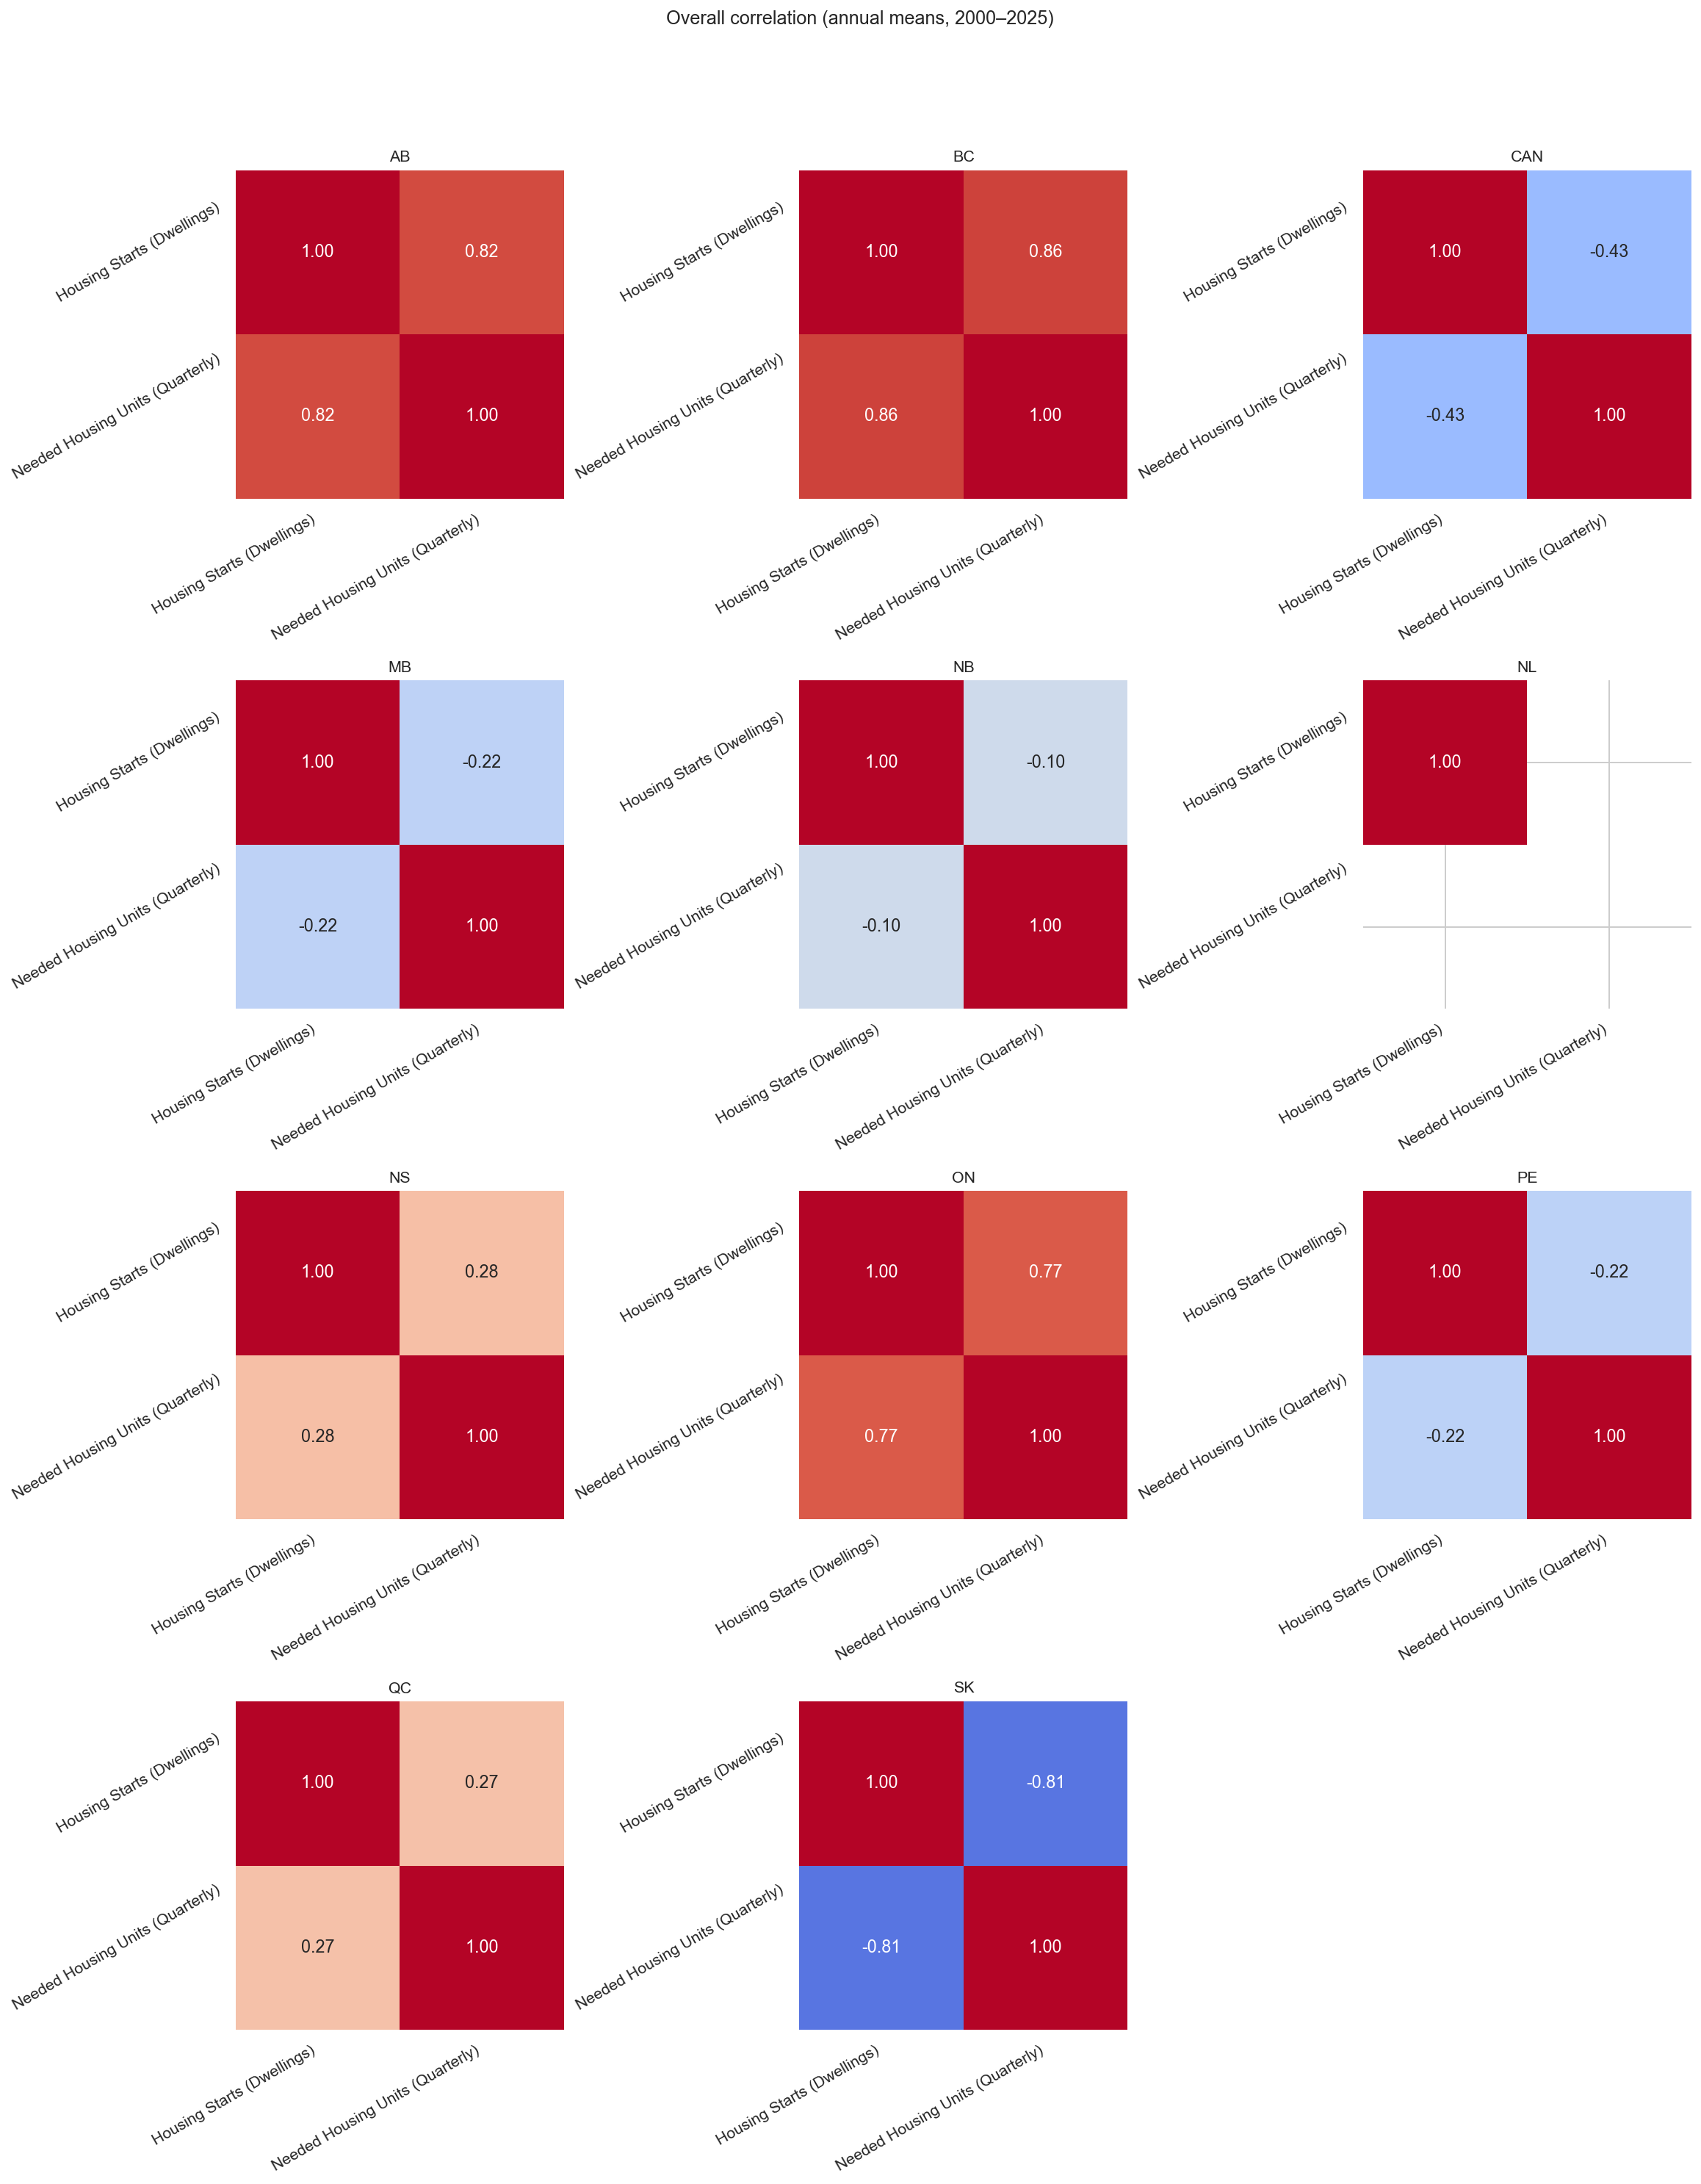

In [ ]:
plot_corr_over_period(
    df=df,
    cols=["dwelling_starts", "needed_units_q"],
    by_province=True,
    start="1995-01-01",
    end="2000-12-31",
    freq="A",
    method="pearson",
    title="Overall correlation (annual means, 2000–2025)"
)

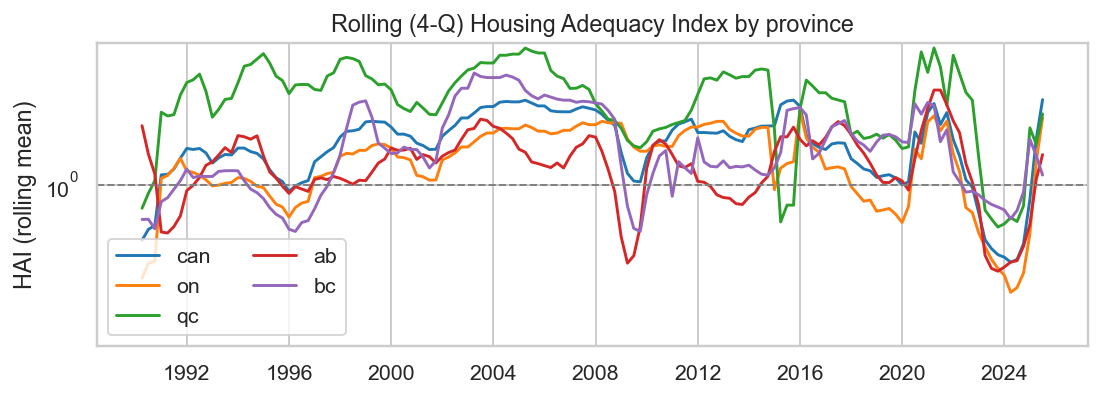

In [ ]:
#Relative adequacy trends (HAI over time): Assess when provinces move from shortage to surplus.
def plot_hai_trend(df, provinces=None):
    provinces = provinces or ["can","on","qc","ab","bc"]
    plt.figure(figsize=(8,3))
    for p in provinces:
        sub = df[df["province"]==p].sort_values("quarter")
        plt.plot(sub["quarter"].dt.to_timestamp(), sub["hai"].rolling(4, min_periods=2).mean(), label=p)
    plt.axhline(1, color="gray", ls="--", lw=1)
    plt.legend(loc=3, ncol=2)
    plt.title("Rolling (4-Q) Housing Adequacy Index by province")
    plt.ylabel("HAI (rolling mean)")
    plt.tight_layout()
    plt.yscale("symlog", linthresh=0.1)
    plt.show()
plot_hai_trend(df)

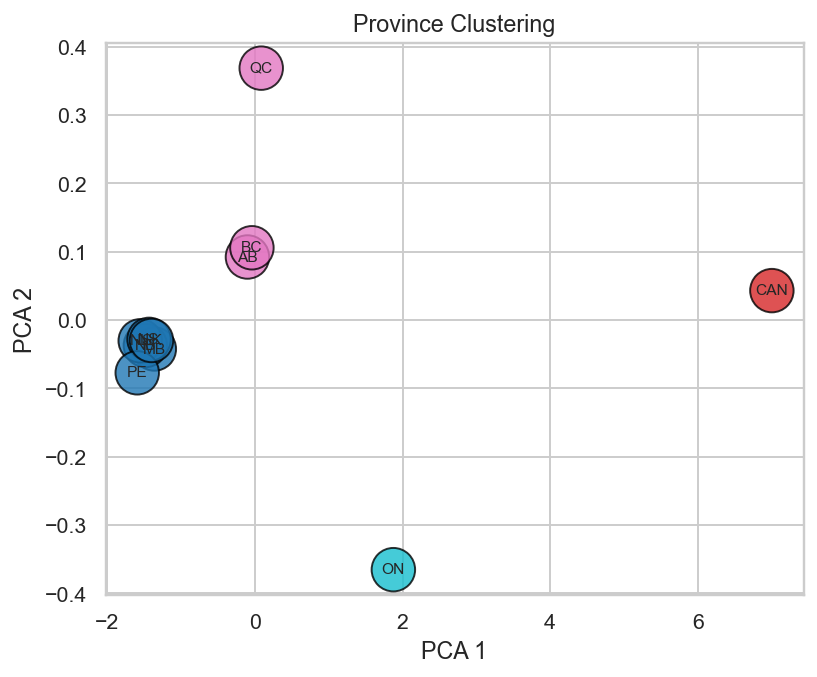

In [ ]:
# %% [ipython] Province clustering — housing–population dynamics (uppercase labels)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate stats per province
agg = (
    df.groupby("province")[["dwelling_starts", "needed_units_q"]]
      .agg(["mean", "std", "median"])
)

# Standardize features
X = StandardScaler().fit_transform(agg.values)

# PCA for visualization
pca = PCA(n_components=3, random_state=42)
coords = pca.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(coords)

# Prepare uppercase province labels
prov_labels = [p.upper() for p in agg.index]

# Plot
plt.figure(figsize=(6, 5))
sns.set_context("notebook")
sns.set_style("whitegrid")

plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap="tab10", s=500, edgecolor="k", alpha=0.8)
for i, label in enumerate(prov_labels):
    plt.text(coords[i, 0], coords[i, 1], label, fontsize=8, ha="center", va="center")

plt.title("Province Clustering", fontsize=12)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()


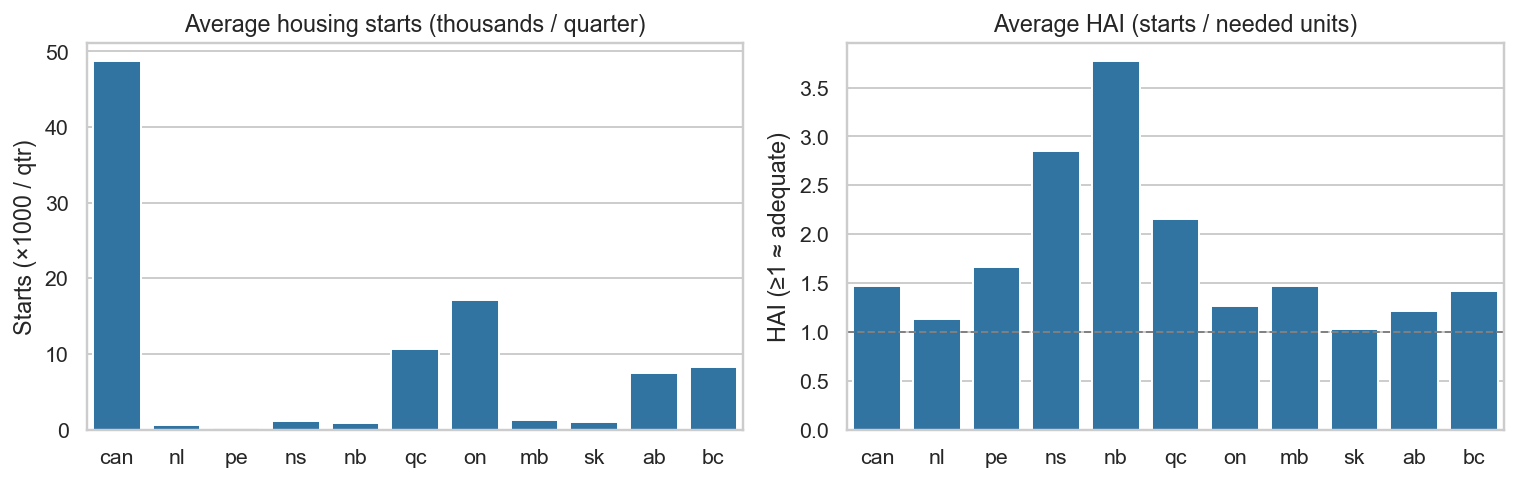

In [ ]:
# --- 3. Province variation (bar charts) ---
# A clean province order (edit to taste)
PROVINCES_ORDER = ["can","nl","pe","ns","nb","qc","on","mb","sk","ab","bc"]
PROVINCE_NAMES = {
    "can": "Canada", "nl": "Newfoundland and Labrador", "pe": "Prince Edward Island",
    "ns": "Nova Scotia", "nb": "New Brunswick", "qc": "Quebec", "on": "Ontario",
    "mb": "Manitoba", "sk": "Saskatchewan", "ab": "Alberta", "bc": "British Columbia",
}

sns.set_style("whitegrid"); sns.set_context("notebook")

order = [p for p in PROVINCES_ORDER if p in df["province"].unique()]

means = (
    df.groupby("province")[["starts_saar_q","hai"]]
      .mean()
      .reindex(order)
      .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(11, 3.6))
sns.barplot(data=means, x="province", y="starts_saar_q", order=order, ax=axes[0])
axes[0].set_title("Average housing starts (thousands / quarter)")
axes[0].set_xlabel(""); axes[0].set_ylabel("Starts (×1000 / qtr)")

sns.barplot(data=means, x="province", y="hai", order=order, ax=axes[1])
axes[1].axhline(1, color="gray", ls="--", lw=1)
axes[1].set_title("Average HAI (starts / needed units)")
axes[1].set_xlabel(""); axes[1].set_ylabel("HAI (≥1 ≈ adequate)")

plt.tight_layout(); plt.show()


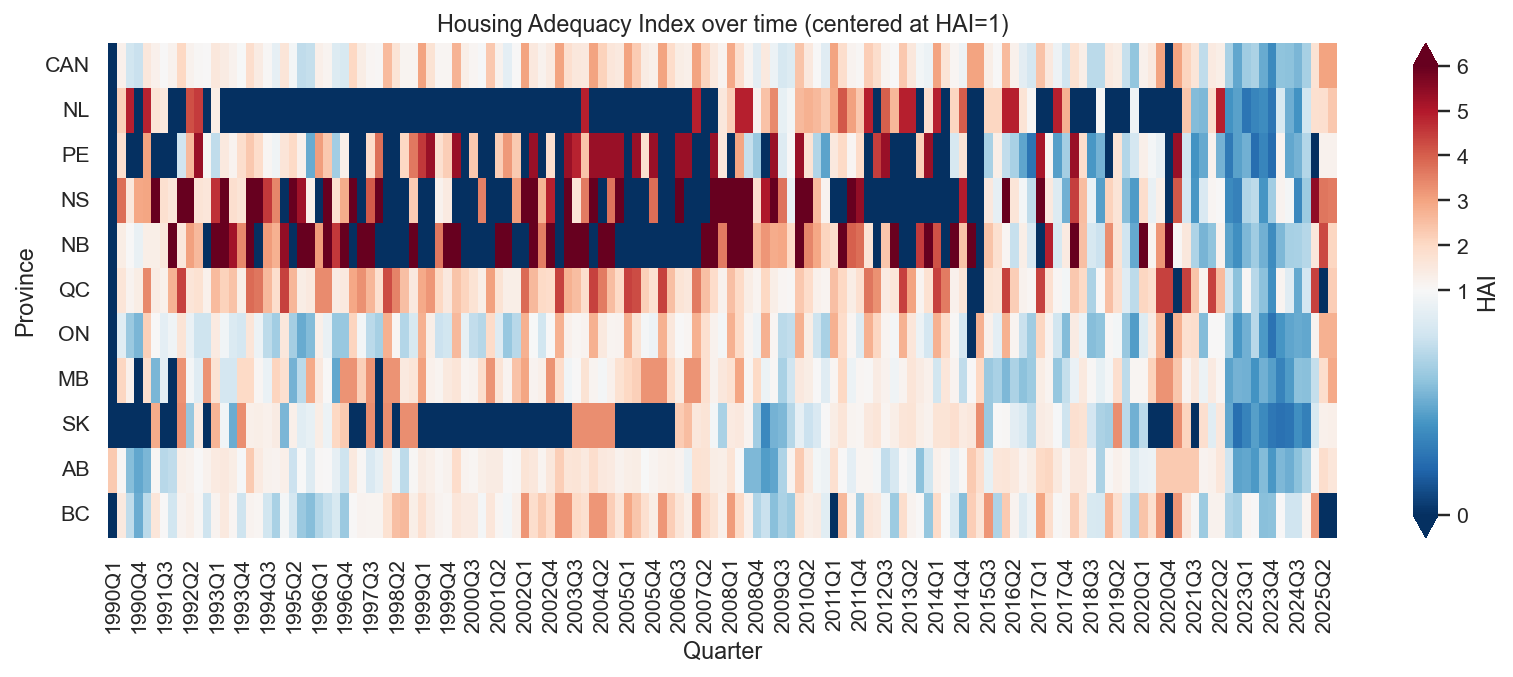

In [ ]:
# --- 5. HAI heatmap (quarter × province), centered at 1 ---
pivot = df.pivot_table(values="hai", index="quarter", columns="province")
pivot = pivot[[c for c in order if c in pivot.columns]]

# Optional: clip color range
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vmin=0, vcenter=1, vmax=6)

plt.figure(figsize=(12, 5))
ax = sns.heatmap(
    pivot.T,
    cmap="RdBu_r",
    norm=norm,
    cbar_kws={"label": "HAI", "extend": "both"}
)

# --- convert y-tick labels to uppercase ---
ax.set_yticklabels([label.get_text().upper() for label in ax.get_yticklabels()], rotation=0)

plt.title("Housing Adequacy Index over time (centered at HAI=1)")
plt.xlabel("Quarter"); plt.ylabel("Province")
plt.tight_layout()
plt.show()
